# Extraindo dados do Twitter

Nesse notebook veremos como realizar a autenticação na API do twitter (1),
exploraremos um pouco o conteúdo dos dados (2),
realizamos a extração de todos os tweets para uma lista de usuários para a criação da camada **RAW** do data lake (3,4 e 5),
e por fim veremos como utilizar uma ferramenta de scheduling para manter esses tweets atualizados (6).

## Indice
1. [Autenticando no twitter](#Autenticando-no-twitter)
2. [Como é a representação de um tweet ?](#Como-é-a-representação-de-um-tweet-?)
3. [Extraindo todos os tweets para um usuário](#Extraindo-todos-os-tweets-para-um-usuário)
4. [Extraindo dados para o data lake](#Extraindo-dados-para-o-data-lake)
5. [Salvando os dados](#Salvando-os-dados)
6. [Como manter os tweets atualizados?](#Como-manter-os-tweets-atualizados?)
7. [Conclusão](#Conclusão)

In [ ]:
# Para obter os dados do datalake, baixe o arquivo disponibilizado no drive
# !unzip datalake.zip -q

In [ ]:
# Caso esteja rodando no colab, baixe o seguinte arquivo do drive para obter os arquivos já processados e o requirements.txt
!unzip start.zip

Archive:  imgs.zip
replace imgs/tweet.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement json (from -r requirements.txt (line 13)) (from versions: none)
ERROR: No matching distribution found for json (from -r requirements.txt (line 13))


## Autenticando no twitter

Para autenticar no twitter precisamos ter uma conta e uma credencial de acesso à API.

Caso não tenha uma conta no twitter, pode criar uma conta em http://twitter.com.br/

Para conseguir acesso a API, é necessário que a conta esteja com e-mail e telefone verificados, e então aplicar para o acesso em https://developer.twitter.com/en/apply-for-access

Na solicitação do acesso, será necessário descrever a utilização que será feita sobre os dados.
Todas as vezes que criei, coloquei que era apenas para propositos educacionais, que iria testar processos de coleta e processamento de dados.

Para acessar suas credenciais, entre em https://developer.twitter.com/en/portal/dashboard, selecione um projeto e será possível acessar as credenciais

In [ ]:
consumer_key = "" # API key
consumer_secret = "" # API key secret
access_token = "" # Access token
access_token_secret = "" # Access token secret

Para extrair os dados do twitter usaremos uma biblioteca chamada tweepy 

In [ ]:
import tweepy

# Autentincando na API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)
if not api.verify_credentials():
    print("Error verifying credentials")

# Como é a representação de um tweet ?

O tweet é representado dentro do python em uma classe, mas para armazermos ou enviarmos esse dado para outro lugares, podemos representar ele também em JSON

### Exemplo de tweet: 

![tweet](./imgs/tweet.png)
URL: https://twitter.com/semcomp/status/1308920925631455233

na URL temos o ID do tweet, e com esse ID conseguimos extrair os dados referentes a esse tweet.


In [ ]:
tweet = api.get_status(id='1308920925631455233')
tweet

Status(_api=<tweepy.api.API object at 0x7f73af08c5c0>, _json={'created_at': 'Thu Sep 24 00:07:21 +0000 2020', 'id': 1308920925631455233, 'id_str': '1308920925631455233', 'text': 'Saiu o cronograma da Semcomp 23!\n\nPara se inscrever, basta preencher o formulário em https://t.co/OWx6gjQR4z https://t.co/UWpO42TZgf', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/OWx6gjQR4z', 'expanded_url': 'http://semcomp.icmc.usp.br', 'display_url': 'semcomp.icmc.usp.br', 'indices': [85, 108]}], 'media': [{'id': 1308920917481971713, 'id_str': '1308920917481971713', 'indices': [109, 132], 'media_url': 'http://pbs.twimg.com/media/Eio4o7WXYAEYjD4.jpg', 'media_url_https': 'https://pbs.twimg.com/media/Eio4o7WXYAEYjD4.jpg', 'url': 'https://t.co/UWpO42TZgf', 'display_url': 'pic.twitter.com/UWpO42TZgf', 'expanded_url': 'https://twitter.com/semcomp/status/1308920925631455233/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1000, 'h': 1000,

In [ ]:
tweet._json

{'contributors': None,
 'coordinates': None,
 'created_at': 'Thu Sep 24 00:07:21 +0000 2020',
 'entities': {'hashtags': [],
  'media': [{'display_url': 'pic.twitter.com/UWpO42TZgf',
    'expanded_url': 'https://twitter.com/semcomp/status/1308920925631455233/photo/1',
    'id': 1308920917481971713,
    'id_str': '1308920917481971713',
    'indices': [109, 132],
    'media_url': 'http://pbs.twimg.com/media/Eio4o7WXYAEYjD4.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/Eio4o7WXYAEYjD4.jpg',
    'sizes': {'large': {'h': 1000, 'resize': 'fit', 'w': 1000},
     'medium': {'h': 1000, 'resize': 'fit', 'w': 1000},
     'small': {'h': 680, 'resize': 'fit', 'w': 680},
     'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
    'type': 'photo',
    'url': 'https://t.co/UWpO42TZgf'}],
  'symbols': [],
  'urls': [{'display_url': 'semcomp.icmc.usp.br',
    'expanded_url': 'http://semcomp.icmc.usp.br',
    'indices': [85, 108],
    'url': 'https://t.co/OWx6gjQR4z'}],
  'user_mentions': []},


In [ ]:
print("Name:", tweet.user.name)
print("Username:", tweet.user.screen_name)
print("Text:", tweet.text)
print("Favorite count:", tweet.favorite_count)
print("RT count:", tweet.retweet_count)
print("Other content:", tweet.extended_entities)


Name: Semcomp 23
Username: semcomp
Text: Saiu o cronograma da Semcomp 23!

Para se inscrever, basta preencher o formulário em https://t.co/OWx6gjQR4z https://t.co/UWpO42TZgf
Favorite count: 59
RT count: 27
Other content: {'media': [{'id': 1308920917481971713, 'id_str': '1308920917481971713', 'indices': [109, 132], 'media_url': 'http://pbs.twimg.com/media/Eio4o7WXYAEYjD4.jpg', 'media_url_https': 'https://pbs.twimg.com/media/Eio4o7WXYAEYjD4.jpg', 'url': 'https://t.co/UWpO42TZgf', 'display_url': 'pic.twitter.com/UWpO42TZgf', 'expanded_url': 'https://twitter.com/semcomp/status/1308920925631455233/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1000, 'h': 1000, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'large': {'w': 1000, 'h': 1000, 'resize': 'fit'}, 'small': {'w': 680, 'h': 680, 'resize': 'fit'}}}, {'id': 1308920917481918465, 'id_str': '1308920917481918465', 'indices': [109, 132], 'media_url': 'http://pbs.twimg.com/media/Eio4o7WWkAESL9f.jpg', 'media_url_https

## Extraindo todos os tweets para um usuário


Conseguimos utilizar o método [api.user_timeline](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/api-reference/get-statuses-user_timeline) para extrair até 3200 tweets de um usuário, mas essa API tem uma limitação de 200 tweets por request. 

In [ ]:
username = 'semcomp'
tweets = api.user_timeline(
    screen_name=username, # Nome do usuário
    count=200, # Número de tweets por request (máximo 200)
    include_rts=False, # Se querermos trazer os RTs
    max_id=None, # Retorna apenas os IDs mais velhos ou igual ao especificado 
    tweet_mode='extended' # por default vem apenas 140 caracteres.
)
print("Quantidade de tweets", len(tweets))


Quantidade de tweets 160


In [ ]:
tweets[0:5]

[Status(_api=<tweepy.api.API object at 0x7f73af08c5c0>, _json={'created_at': 'Fri Oct 02 15:09:14 +0000 2020', 'id': 1312046992063901702, 'id_str': '1312046992063901702', 'full_text': 'Mais um dia de Semcomp,\nmais um dia de cuponzinho\n\nPra retirar, já sabe:\nsó contatar a Semcomp em uma das nossas redes sociais ou falar com qualquer membro da organização.\n\nInstagram: @semcomp\nFacebook: https://t.co/dc3KP3yvPZ https://t.co/zwlrJOW1C5', 'truncated': False, 'display_text_range': [0, 226], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'semcomp', 'name': 'Semcomp 23', 'id': 16714079, 'id_str': '16714079', 'indices': [184, 192]}], 'urls': [{'url': 'https://t.co/dc3KP3yvPZ', 'expanded_url': 'http://fb.com/semcomp', 'display_url': 'fb.com/semcomp', 'indices': [203, 226]}], 'media': [{'id': 1312046907930415106, 'id_str': '1312046907930415106', 'indices': [227, 250], 'media_url': 'http://pbs.twimg.com/media/EjVTthPXkAILCIY.jpg', 'media_url_https': 'https://p

Então podemos implementar um processo que extrai todos os tweets possíveis para um usuário

In [ ]:
def extract_all_tweets_for_user(api, username):

    has_more_tweets = True
    print(f"Getting tweets for user {username}")
    all_tweets = []
    latest_id = None

    while has_more_tweets:
        tweets = api.user_timeline(screen_name=username,
                                   count=200, # Número máximo de tweets permitidos por request
                                   include_rts=False,
                                   max_id=latest_id,
                                   tweet_mode='extended' # por default vem apenas 140 caracteres.
                                  )
        all_tweets.extend(tweets)
        if not tweets:
            has_more_tweets = False
        else:
            latest_id = tweets[-1].id - 1

    print(f"Tweets collected {len(all_tweets)}")

    return all_tweets

# Extraindo dados para o data lake
Agora para a criação do nosso data lake, podemos definir uma lista de usuários que temos interesse, e coletar todos os tweets desse usuário

In [ ]:
users = [
    'semcomp',
    'cauemoura',
    'lucasinutilismo',
    'Marcelodedois',
    'gduvivier',
    'FabioPorchat',
    'rafaportugalc',
    'PaolaCarosella',
    'whindersson',
    'pefabiodemelo',
    'thatilopes',
    'Tatawerneck'
]

len(users)

12

In [ ]:
tweet_list = []
for username in users:
    user_tts = extract_all_tweets_for_user(api, username)
    tweet_list.extend(user_tts)
    
print(f"Total of collected tweets: {len(tweet_list)}")

Getting tweets for user semcomp
Tweets collected 722
Getting tweets for user cauemoura
Tweets collected 343
Getting tweets for user lucasinutilismo
Tweets collected 3180
Getting tweets for user Marcelodedois
Tweets collected 2048
Getting tweets for user gduvivier
Tweets collected 2272
Getting tweets for user FabioPorchat
Tweets collected 2326
Getting tweets for user rafaportugalc
Tweets collected 2878
Getting tweets for user PaolaCarosella
Tweets collected 2514
Getting tweets for user whindersson


RateLimitError: ignored

In [ ]:
len(tweet_list)

16283

# Salvando os dados

Vamos salvar os tweets coletados em nosso data lake, organizando por usuário e data de coleta, identificando cada tweet em um arquivo no formato json, com seu ID no nome 

In [ ]:
# Organizando os dados por usuário e data
datalake_raw_user_path = "datalake/raw/tweets/{username}/dt={date}/hr={hour}"

Nós também poderiamos organizar por data e depois por usuário

```
datalake_raw_user_path = "datalake/raw/tweets/dt={date}/hr={hour}/{username}"
```

**Qual é a diferença entre essas abordagens?**
- Como conseguimos recuperar nossos dados, caso seja mais interessante obter todos os tweets coletados em um dia, é melhor colocar a data primeiro, assim conseguimos filtrar por dia apenas com o path e sem ter que escolher os usuários, e vice versa.


In [ ]:
import os
import json
from datetime import datetime

def write_tweets_to_datalake(tweet_list):
    # Organizando os dados por usuário e data
    datalake_raw_user_path = "datalake/raw/tweets/{username}/dt={date}/hr={hour}"
    # datalake_raw_user_path = "datalake/raw/tweets/dt={date}/hr={hour}/{username}"


    # Writing files on disk
    for tweet in tweet_list:
        now = datetime.now()
        date = now.strftime("%Y-%m-%d")
        hour = now.strftime("%H")

        tweet_id = tweet.id
        username = tweet.user.screen_name

        path = datalake_raw_user_path.format(
            username=username,
            date=date,
            hour=hour
        )
        ##comentar
        os.makedirs(path, exist_ok=True)

        fname = f"{tweet_id}.json"
        fpath = os.path.join(path, fname)

        data = json.dumps(tweet._json) 

        with open(fpath, 'w') as fp:
            fp.write(data)

write_tweets_to_datalake(tweet_list)

In [ ]:
# Apenas se já tiver os dados salvos !!!
!ls datalake/raw/tweets/semcomp/dt=2020-10-02/

'hr=15'  'hr=20'


## Como manter os tweets atualizados?

Agora temos os ultimos tweets de cada usuário até o momento. 

Mas e se eles fizerem um novo tweet, como faremos? 

Como vamos manter nossa base atualizada?

Podemos utilizar uma ferramenta de scheduling, 
como o [Apache Airflow](https://airflow.apache.org/), e agendar a extração dos para a cada uma hora, por exemplo.

O Airflow é uma ferramenta open source, com uma ótima [User Interface](https://airflow.apache.org/docs/stable/ui.html) para o gerenciamento de jobs e conexões de forma segura

![UI](https://airflow.apache.org/docs/stable/_images/dags.png)

Vamos supor que criaremos um schedule para a cada uma hora (['0 * * * *'](https://crontab.guru/#0_*_*_*_*)) para rodar o código abaixo

In [ ]:
import glob
import re

def get_most_recent_date(date_list, split, pattern):
    if not date_list:
        return None
    date = date_list[0]
    date = date.split(split)[-1]
    
    latest = datetime.strptime(date, pattern)
    for date in date_list:
        date = date.split(split)[-1]
        date = datetime.strptime(date, pattern)
        if latest < date:
            latest = date
            
    return latest.strftime(pattern)


# Pegando o último ID coletado para cada usuário
# Aqui não precisamos abrir os arquivos, mas poderiamos armazenar essa info atualizada em um banco de dados

# Por exemplo:
user = users[0]

# Encontrando no datalake a última data coletada para esse usuário
splited_path = datalake_raw_user_path.split('/')
print("splited_path", splited_path)

start_path =  splited_path[:3]
print("start_path", start_path)

splited_user_path = start_path + [user, '*']
print("splited_user_path", splited_user_path)

path = os.path.join(*splited_user_path)
print("path", path)

date_list = glob.glob(path)
print("date_list", date_list)

latest_date = get_most_recent_date(date_list,split='dt=', pattern="%Y-%m-%d")
print("latest_date", latest_date)

splited_path ['datalake', 'raw', 'tweets', '{username}', 'dt={date}', 'hr={hour}']
start_path ['datalake', 'raw', 'tweets']
splited_user_path ['datalake', 'raw', 'tweets', 'semcomp', '*']
path datalake/raw/tweets/semcomp/*
date_list ['datalake/raw/tweets/semcomp/dt=2020-10-02']
latest_date 2020-10-02


In [ ]:
# Encontrando no datalake a última hora coletada para esse usuário
splited_date_path = start_path + [user, f'dt={latest_date}', '*']
print("splited_date_path", splited_date_path)

path = os.path.join(*splited_date_path)
print("path", path)

hour_list = glob.glob(path)
print("hour_list", hour_list)

latest_hour = get_most_recent_date(hour_list,split='hr=', pattern="%H")
print("latest_hour", latest_hour)

splited_date_path ['datalake', 'raw', 'tweets', 'semcomp', 'dt=2020-10-02', '*']
path datalake/raw/tweets/semcomp/dt=2020-10-02/*
hour_list ['datalake/raw/tweets/semcomp/dt=2020-10-02/hr=20', 'datalake/raw/tweets/semcomp/dt=2020-10-02/hr=15']
latest_hour 20


In [ ]:
# Pegando a lista de todos os Ids dentro daquela hora
ids_path = start_path + [user, f'dt={latest_date}',f'hr={latest_hour}', '*']
print("ids_path", ids_path)

path = os.path.join(*ids_path)
print("path", path)

files = glob.glob(path)
print(files[0:2])

# Pegando o maior ID

id_list = list(
                map(
                    lambda path: int(
                        re.findall(r'/(\d+)\.json', path)[0]
                    ),
                    files
                )
            )
print("id_list", id_list[0:3])

ids_path ['datalake', 'raw', 'tweets', 'semcomp', 'dt=2020-10-02', 'hr=20', '*']
path datalake/raw/tweets/semcomp/dt=2020-10-02/hr=20/*
['datalake/raw/tweets/semcomp/dt=2020-10-02/hr=20/901560748937273349.json', 'datalake/raw/tweets/semcomp/dt=2020-10-02/hr=20/73083517902401536.json']
id_list [901560748937273349, 73083517902401536, 501212237722574848]


In [ ]:
# Função para extrair a lista de IDs para um usuário
def get_datalake_id_list_for_user(username, datalake_raw_user_path):

    splited_path = datalake_raw_user_path.split('/')
    start_path =  splited_path[:3]
   
    splited_user_path = start_path + [user, '*']
    path = os.path.join(*splited_user_path)
    
    date_list = glob.glob(path)
    latest_date = get_most_recent_date(date_list,split='dt=', pattern="%Y-%m-%d")
    splited_date_path = start_path + [user, f'dt={latest_date}', '*']
    path = os.path.join(*splited_date_path)
    
    hour_list = glob.glob(path)
    latest_hour = get_most_recent_date(hour_list,split='hr=', pattern="%H")
    
    ids_path = start_path + [user, f'dt={latest_date}',f'hr={latest_hour}', '*']
    path = os.path.join(*ids_path)
    files = glob.glob(path)

    # Retornando lista de IDS
    return list(
                map(
                    lambda path: int(
                        re.findall(r'/(\d+)\.json', path)[0]
                    ),
                    files
                )
            )


In [ ]:
# Para todos os usuários definidos, coletamos novos dados a cada hora
for user in users:
    print(f"Getting tweets for user {user}")
    our_ids = get_datalake_id_list_for_user(user, datalake_raw_user_path)
    our_ids = set(our_ids) # O set é mais rápido para fazer buscas
    latest_id = None
    while True:
        tweets = api.user_timeline(screen_name=user,
                                       count=200,
                                       include_rts=False,
                                       max_id=latest_id,
                                       tweet_mode='extended'
                                      )
        missing_tweets = [tt for tt in tweets if tt.id not in our_ids]
        write_tweets_to_datalake(missing_tweets)
        if missing_tweets:
            print(f"{len(missing_tweets)} new tweets for {user}")
            [our_ids.add(tt.id) for tt in missing_tweets]
        else:
            latest_id = tweets[-1].id - 1
            break


Getting tweets for user semcomp
Getting tweets for user cauemoura
Getting tweets for user lucasinutilismo
Getting tweets for user Marcelodedois
Getting tweets for user gduvivier
Getting tweets for user FabioPorchat
Getting tweets for user rafaportugalc
Getting tweets for user PaolaCarosella
3 new tweets for PaolaCarosella
Getting tweets for user whindersson
5 new tweets for whindersson
Getting tweets for user pefabiodemelo
1 new tweets for pefabiodemelo
Getting tweets for user thatilopes
Getting tweets for user Tatawerneck


# Conclusão

Conseguimos realizar a extração e o armazenamento dos nossos dados na primeira camada "RAW" do nosso data lake, os dados estão particionado por usuário, data e hora de coleta.

# Transformando e armazenando os dados do data lake

Nosso objetivo é transformar nossos dados para facilitar a analise e o processamento desses dados.

Para isso, criaremos um conjunto de dados estruturados utilizando a biblioteca pandas, simulando uma tabela em um banco de dados, e armazenado na camada trusted do nosso data lake em CSV.

Nossos dados de interesse são:
- texto do tweet
- usuário
- data de criação do tweet
- numero de vezes que foi retuitado
- numero de vezes que foi favoritado

Adicionalmente, vamos fazer a tradução dos tweets para o inglês utilizando o google tradutor deixando os dados preparados para algoritmos de analise em inglês.



In [ ]:
import glob
import json
import unidecode
from collections import Counter

# Lendo e processando os dados

In [ ]:
# datalake/raw/tweets/{username}/dt={date}/hr={hour}/{id}.json
files = glob.glob('datalake/raw/tweets/*/*/*/*')
print(f"Quantidade de tweets: {len(files)}")
files[0:10]

Quantidade de tweets: 42649


['datalake/raw/tweets/gduvivier/dt=2020-10-02/hr=20/1139175135850696704.json',
 'datalake/raw/tweets/gduvivier/dt=2020-10-02/hr=20/1298979887731048448.json',
 'datalake/raw/tweets/gduvivier/dt=2020-10-02/hr=20/1117840857363877892.json',
 'datalake/raw/tweets/gduvivier/dt=2020-10-02/hr=20/1310312682575273987.json',
 'datalake/raw/tweets/gduvivier/dt=2020-10-02/hr=20/1264715605841776641.json',
 'datalake/raw/tweets/gduvivier/dt=2020-10-02/hr=20/1242255061964787712.json',
 'datalake/raw/tweets/gduvivier/dt=2020-10-02/hr=20/1234845283630145536.json',
 'datalake/raw/tweets/gduvivier/dt=2020-10-02/hr=20/1308236013970624513.json',
 'datalake/raw/tweets/gduvivier/dt=2020-10-02/hr=20/1257471756476076032.json',
 'datalake/raw/tweets/gduvivier/dt=2020-10-02/hr=20/1258491818230104064.json']

## Explorando nossos dados
[Documentação do objeto tweet](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/tweet-object
)

In [ ]:
sample = files[0]
with open(sample, 'r') as f:
    data = f.read()

print(f"Tipo: {type(data)}")
print(f"Conteúdo:\n{data[:100]}...")

Tipo: <class 'str'>
Conteúdo:
{"created_at": "Thu Jun 13 14:18:11 +0000 2019", "id": 1139175135850696704, "id_str": "1139175135850...


Transformando nosso JSON em um dicionário


In [ ]:
data = json.loads(data)
print(f"Tipo: {type(data)}")

# Iterando sobre todos campos do dicionário
for key, value in data.items():
    print("key:", key)
    print("\tvalue:", value)
    print()

Tipo: <class 'dict'>
key: created_at
	value: Thu Jun 13 14:18:11 +0000 2019

key: id
	value: 1139175135850696704

key: id_str
	value: 1139175135850696704

key: full_text
	value: CIÚMES 2! https://t.co/9JirqkPLWE

key: truncated
	value: False

key: display_text_range
	value: [0, 33]

key: entities
	value: {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/9JirqkPLWE', 'expanded_url': 'https://www.youtube.com/watch?v=StGTFuh1zwQ', 'display_url': 'youtube.com/watch?v=StGTFu…', 'indices': [10, 33]}]}

key: source
	value: <a href="https://ifttt.com" rel="nofollow">IFTTT</a>

key: in_reply_to_status_id
	value: None

key: in_reply_to_status_id_str
	value: None

key: in_reply_to_user_id
	value: None

key: in_reply_to_user_id_str
	value: None

key: in_reply_to_screen_name
	value: None

key: user
	value: {'id': 25704704, 'id_str': '25704704', 'name': 'Gregorio Duvivier', 'screen_name': 'gduvivier', 'location': 'Rio', 'description': 'segunda, quinta e sábado no po

In [ ]:
# Listando todos campos disponíveis
for key in data.keys():
    print(key)

created_at
id
id_str
full_text
truncated
display_text_range
entities
source
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
user
geo
coordinates
place
contributors
is_quote_status
retweet_count
favorite_count
favorited
retweeted
possibly_sensitive
lang


In [ ]:
data['user']['name']

'Gregorio Duvivier'

In [ ]:
# Função para mapear os campos de interesse
def extract_columns(tweet):
    return {
     "id": tweet['id'],
     "created_at": tweet['created_at'],
     "username":tweet['user']['screen_name'],
     "favorite_count": tweet['favorite_count'],
     "retweet_count": tweet['retweet_count'],
     "text": tweet['full_text'],
    }

In [ ]:
extract_columns(data)

{'created_at': 'Thu Jun 13 14:18:11 +0000 2019',
 'favorite_count': 71,
 'id': 1139175135850696704,
 'retweet_count': 2,
 'text': 'CIÚMES 2! https://t.co/9JirqkPLWE',
 'username': 'gduvivier'}

In [ ]:
# Para todos os tweets vamos extrair apenas os campos de interesse

table_rows = []
for fname in files:
    with open(fname, 'r') as fp:
        tweet_json = fp.read()
    
    tweet = json.loads(tweet_json)
    row = extract_columns(tweet)
    table_rows.append(row)
    

In [ ]:
table_rows[0]

{'created_at': 'Thu Jun 13 14:18:11 +0000 2019',
 'favorite_count': 71,
 'id': 1139175135850696704,
 'retweet_count': 2,
 'text': 'CIÚMES 2! https://t.co/9JirqkPLWE',
 'username': 'gduvivier'}

In [ ]:
len(table_rows)

42649

# Criando uma base tabular estruturada

Vamos converter nossa base em JSON para um formato tabular utilizando o pandas

In [ ]:
import pandas as pd
import numpy as np


columns = ['created_at', 'id', 'username', 'text', 'retweet_count', 'favorite_count', 'text_en']

df = pd.DataFrame(table_rows, columns=columns)
df['text_en'] = '' # Definindo texto em inglês como string vazia
df.head()


,created_at,id,username,text,retweet_count,favorite_count,text_en
0,Thu Jun 13 14:18:11 +0000 2019,1139175135850696704,gduvivier,CIÚMES 2! https://t.co/9JirqkPLWE,2,71,
1,Thu Aug 27 13:45:13 +0000 2020,1298979887731048448,gduvivier,to lá https://t.co/pVSYNiBq3r,10,99,
2,Mon Apr 15 17:23:23 +0000 2019,1117840857363877892,gduvivier,alguém tem o contato do Atila KW da banda Konv...,0,78,
3,Sun Sep 27 20:17:42 +0000 2020,1310312682575273987,gduvivier,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,716,7675,
4,Mon May 25 00:31:12 +0000 2020,1264715605841776641,gduvivier,"Também fiquei mal, como perceberam pela minha ...",6,282,


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42649 entries, 0 to 42648
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created_at      42649 non-null  object
 1   id              42649 non-null  int64 
 2   username        42649 non-null  object
 3   text            42649 non-null  object
 4   retweet_count   42649 non-null  int64 
 5   favorite_count  42649 non-null  int64 
 6   text_en         42649 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.3+ MB


## Tratando os dados

In [ ]:
df['created_at']

0        Thu Jun 13 14:18:11 +0000 2019
1        Thu Aug 27 13:45:13 +0000 2020
2        Mon Apr 15 17:23:23 +0000 2019
3        Sun Sep 27 20:17:42 +0000 2020
4        Mon May 25 00:31:12 +0000 2020
                      ...              
42644    Wed Dec 31 00:11:01 +0000 2014
42645    Wed Oct 23 05:09:59 +0000 2013
42646    Wed Aug 21 03:43:07 +0000 2013
42647    Sat Oct 05 02:31:14 +0000 2013
42648    Fri Oct 23 15:47:44 +0000 2009
Name: created_at, Length: 42649, dtype: object

### createdAt

O formato de data apresentado `Thu Sep 26 17:54:57 +0000 2019` não é interessante para salvarmos em bases de dados mais estruturadas, pois não conseguimos fazer comparações e analises, então vamos parsear e transformar em datetime, um dos formatos de data aceitos em banco de dados

Na tabela [strptime behavior](https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior) conseguimos ver quais são os padroẽs de data e hora definidos

![strptime_behavior](../imgs/strfpime_behavior.png)



Trabalhar com dados tabulares facilita a aplicação de funções em apenas uma coluna

In [ ]:
from datetime import datetime

df['created_at'].apply(lambda dt: datetime.strptime(dt, '%a %b %d %H:%M:%S %z %Y'))

0       2019-06-13 14:18:11+00:00
1       2020-08-27 13:45:13+00:00
2       2019-04-15 17:23:23+00:00
3       2020-09-27 20:17:42+00:00
4       2020-05-25 00:31:12+00:00
                   ...           
42644   2014-12-31 00:11:01+00:00
42645   2013-10-23 05:09:59+00:00
42646   2013-08-21 03:43:07+00:00
42647   2013-10-05 02:31:14+00:00
42648   2009-10-23 15:47:44+00:00
Name: created_at, Length: 42649, dtype: datetime64[ns, UTC]

In [ ]:
def parse_time(dt):
  return datetime.strptime(dt, '%a %b %d %H:%M:%S %z %Y')

df['created_at'].apply(parse_time)


0       2019-06-13 14:18:11+00:00
1       2020-08-27 13:45:13+00:00
2       2019-04-15 17:23:23+00:00
3       2020-09-27 20:17:42+00:00
4       2020-05-25 00:31:12+00:00
                   ...           
42644   2014-12-31 00:11:01+00:00
42645   2013-10-23 05:09:59+00:00
42646   2013-08-21 03:43:07+00:00
42647   2013-10-05 02:31:14+00:00
42648   2009-10-23 15:47:44+00:00
Name: created_at, Length: 42649, dtype: datetime64[ns, UTC]

In [ ]:
df.head()

,created_at,id,username,text,retweet_count,favorite_count,text_en
0,Thu Jun 13 14:18:11 +0000 2019,1139175135850696704,gduvivier,CIÚMES 2! https://t.co/9JirqkPLWE,2,71,
1,Thu Aug 27 13:45:13 +0000 2020,1298979887731048448,gduvivier,to lá https://t.co/pVSYNiBq3r,10,99,
2,Mon Apr 15 17:23:23 +0000 2019,1117840857363877892,gduvivier,alguém tem o contato do Atila KW da banda Konv...,0,78,
3,Sun Sep 27 20:17:42 +0000 2020,1310312682575273987,gduvivier,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,716,7675,
4,Mon May 25 00:31:12 +0000 2020,1264715605841776641,gduvivier,"Também fiquei mal, como perceberam pela minha ...",6,282,


In [ ]:
df['created_at'] = df['created_at'].apply(lambda dt: datetime.strptime(dt, '%a %b %d %H:%M:%S %z %Y'))

In [ ]:
df.head()

,created_at,id,username,text,retweet_count,favorite_count,text_en
0,2019-06-13 14:18:11+00:00,1139175135850696704,gduvivier,CIÚMES 2! https://t.co/9JirqkPLWE,2,71,
1,2020-08-27 13:45:13+00:00,1298979887731048448,gduvivier,to lá https://t.co/pVSYNiBq3r,10,99,
2,2019-04-15 17:23:23+00:00,1117840857363877892,gduvivier,alguém tem o contato do Atila KW da banda Konv...,0,78,
3,2020-09-27 20:17:42+00:00,1310312682575273987,gduvivier,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,716,7675,
4,2020-05-25 00:31:12+00:00,1264715605841776641,gduvivier,"Também fiquei mal, como perceberam pela minha ...",6,282,


In [ ]:
df['created_at'].values[0]

numpy.datetime64('2019-06-13T14:18:11.000000000')

## Analisando a qualidade dos nossos dados

In [ ]:
# Quantidade de tweets
df.shape

(42649, 7)

In [ ]:
# Quantidade de tweets por usuário
df.groupby("username").id.count()

username
FabioPorchat       4650
Marcelodedois      4094
PaolaCarosella     5031
Tatawerneck        2120
cauemoura           683
gduvivier          4543
lucasinutilismo    6358
pefabiodemelo      3225
rafaportugalc      5758
semcomp            1444
thatilopes         2181
whindersson        2562
Name: id, dtype: int64

In [ ]:
# Quantidade de tweets únicos por usuário
df.groupby("username").id.nunique()

username
FabioPorchat       2326
Marcelodedois      2048
PaolaCarosella     2517
Tatawerneck        2120
cauemoura           343
gduvivier          2272
lucasinutilismo    3180
pefabiodemelo      3225
rafaportugalc      2881
semcomp             722
thatilopes         2181
whindersson        2562
Name: id, dtype: int64

In [ ]:
# Usuários onde existem tweets duplicados, que podem ter sido coletados mais de uma vez
df.groupby("username").id.count() != df.groupby("username").id.nunique()

username
FabioPorchat        True
Marcelodedois       True
PaolaCarosella      True
Tatawerneck        False
cauemoura           True
gduvivier           True
lucasinutilismo     True
pefabiodemelo      False
rafaportugalc       True
semcomp             True
thatilopes         False
whindersson        False
Name: id, dtype: bool

## Deduplicando dados

A remoção de dados duplicados é um trabalho bem comum, a duplicação pode acontecer por conta de erros no processamento e retentativa (em alguns casos é melhor duplicar do que perder uma informação), em alguns casos é necessário manter a última versão para cada ID.

No nosso caso, como o texto do tweet não é alterado, vamos apenas manter aleatóriamente um dos IDs, mas assim estaremos perdendo a informação de RT e favoritados.

In [ ]:
print("Before deduplication", df.shape)
# Removendo tweets duplicados caso eles existam
df = df.drop_duplicates(subset=['username', 'id'])
print("After deduplication", df.shape)

Before deduplication (42649, 7)
After deduplication (26377, 7)


# Enriquecendo nossa base

Já processamos e estruturamos nossos dados, e sabendo que nossos analistas e ciêntistas de dados precisam desse dado em inglês vamos realizar a tradução da nossa base utilizando o [google translator](https://py-googletrans.readthedocs.io/en/latest/).

In [ ]:
df.head()

,created_at,id,username,text,retweet_count,favorite_count,text_en
0,2019-06-13 14:18:11+00:00,1139175135850696704,gduvivier,CIÚMES 2! https://t.co/9JirqkPLWE,2,71,
1,2020-08-27 13:45:13+00:00,1298979887731048448,gduvivier,to lá https://t.co/pVSYNiBq3r,10,99,
2,2019-04-15 17:23:23+00:00,1117840857363877892,gduvivier,alguém tem o contato do Atila KW da banda Konv...,0,78,
3,2020-09-27 20:17:42+00:00,1310312682575273987,gduvivier,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,716,7676,
4,2020-05-25 00:31:12+00:00,1264715605841776641,gduvivier,"Também fiquei mal, como perceberam pela minha ...",6,282,


In [ ]:
!pip install googletrans

In [ ]:
from googletrans import Translator
translator = Translator()

In [ ]:
translations = translator.translate("Oi meu nome é Marcos e hoje estou apresentando na Semcomp", src='pt', dst='en')
translations.text

"Hi my name is Marcos and today I'm presenting at Semcomp"

Legal, então vamos traduzir nossos textos ...

In [ ]:
from tqdm.notebook import tqdm # Apenas para visualizar o progesso

for idx in tqdm(df.index):
    if df.at[idx, 'text_en'] == '':
        translation = translator.translate(df.at[idx, 'text'])
        df.at[idx, 'text_en'] = translation.text
    # if idx > 50:
    #     break

KeyboardInterrupt: ignored

In [ ]:
df.head()

,created_at,id,username,text,retweet_count,favorite_count,text_en
0,2019-06-13 14:18:11+00:00,1139175135850696704,gduvivier,CIÚMES 2! https://t.co/9JirqkPLWE,2,71,JEALOUS 2! https://t.co/9JirqkPLWE
1,2020-08-27 13:45:13+00:00,1298979887731048448,gduvivier,to lá https://t.co/pVSYNiBq3r,10,99,to lá https://t.co/pVSYNiBq3r
2,2019-04-15 17:23:23+00:00,1117840857363877892,gduvivier,alguém tem o contato do Atila KW da banda Konv...,0,78,does anyone have contact with Atila KW from th...
3,2020-09-27 20:17:42+00:00,1310312682575273987,gduvivier,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,716,7675,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k
4,2020-05-25 00:31:12+00:00,1264715605841776641,gduvivier,"Também fiquei mal, como perceberam pela minha ...",6,282,"I also looked bad, as you can see from my face..."


In [ ]:
translations = translator.translate(["Oi meu nome é Marcos e hoje estou apresentando na Semcomp", "Ola, tudo bem?"], src='pt', dst='en')
for text in translations:
  print(text.text)


# async asyncio

Hi my name is Marcos and today I'm presenting at Semcomp
Hello, how are you?


Conseguimos traduzir alguns textos, mas o processo é bem lento, né?

Essa é uma implementação gratuita e limitada da API, mas poderiamos implementar os requests em batch e concorrentes para conseguir melhor performance.

Para implementar os requests paralelos, podemos utilizar uma API de alto nível, como o [ray](https://github.com/ray-project/ray)

In [ ]:
import ray # Ray provides a simple, universal API for building distributed applications.
import psutil

num_cpus = psutil.cpu_count(logical=False)
print("Number of CPUs", num_cpus)
ray.init(num_cpus=6) # Number of workers

2020-10-02 21:42:14,684	INFO resource_spec.py:231 -- Starting Ray with 7.13 GiB memory available for workers and up to 3.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Number of CPUs 1


2020-10-02 21:42:15,265	INFO services.py:1193 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2020-10-02_21-42-14_681747_341/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2020-10-02_21-42-14_681747_341/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2020-10-02_21-42-14_681747_341',
 'webui_url': 'localhost:8265'}

In [ ]:
# Translation function
@ray.remote
def translate_text(text):
    translator = Translator()
    translation = translator.translate(text)
    return translation.text

In [ ]:
# Set the requests for processing and armazenates the object reference
futures = [translate_text.remote(text) for text in df['text'][0:5]]
print("Futures:\n", futures)
texts_en = ray.get(futures) # Process the requests distributed
print("Texts:\n", texts_en)

Futures:
 [ObjectRef(a0080f23df2729e0ffffffff010000c001000000), ObjectRef(d346e674c840db15ffffffff010000c001000000), ObjectRef(8d273c8584b3dd59ffffffff010000c001000000), ObjectRef(2462c4eb9c1bfa10ffffffff010000c001000000), ObjectRef(01566e830afe8b0affffffff010000c001000000)]
Texts:
 ['JEALOUS 2! https://t.co/9JirqkPLWE', 'to lá https://t.co/pVSYNiBq3r', 'does anyone have contact with Atila KW from the band Konversão?', 'https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k', 'I also looked bad, as you can see from my face. What fell in the case was the left eye https://t.co/IHnkUzdlon']


In [ ]:
# Implementing a batch and parallel aproach
texts_pt = df['text']

batch = []
texts_en = []
batch_size = 50

for text in tqdm(texts_pt):
    batch.append(text)

    if len(batch) < batch_size:
        continue
    futures = [translate_text.remote(text) for text in batch]
    translated_texts = ray.get(futures)

    for translated in translated_texts:
        texts_en.append(translated)
    batch = []

futures = [translate_text.remote(text) for text in batch]
translated_texts = ray.get(futures)

for translated in translated_texts:
    texts_en.append(translated)

KeyboardInterrupt: ignored

In [ ]:
ray.shutdown()

In [ ]:
len(texts_en) == len(texts_pt)

False

In [ ]:
df['text_en'] = texts_en

ValueError: ignored

In [ ]:
df.head()

,created_at,id,username,text,retweet_count,favorite_count,text_en
0,2019-06-13 14:18:11+00:00,1139175135850696704,gduvivier,CIÚMES 2! https://t.co/9JirqkPLWE,2,71,JEALOUS 2! https://t.co/9JirqkPLWE
1,2020-08-27 13:45:13+00:00,1298979887731048448,gduvivier,to lá https://t.co/pVSYNiBq3r,10,99,to lá https://t.co/pVSYNiBq3r
2,2019-04-15 17:23:23+00:00,1117840857363877892,gduvivier,alguém tem o contato do Atila KW da banda Konv...,0,78,does anyone have contact with Atila KW from th...
3,2020-09-27 20:17:42+00:00,1310312682575273987,gduvivier,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,716,7676,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k
4,2020-05-25 00:31:12+00:00,1264715605841776641,gduvivier,"Também fiquei mal, como perceberam pela minha ...",6,282,"I also looked bad, as you can see from my face..."


# Salvando nossos dados estruturados no disco

In [ ]:
import os
os.makedirs('database/trusted/', exist_ok=True)
df.to_csv('database/trusted/tweets.csv', index=False)


In [ ]:
# !mkdir -p database/backup
# !cp database/trusted/tweets.csv tweets_20201002.csv
!head database/trusted/tweets.csv

created_at,id,username,text,retweet_count,favorite_count,text_en
2019-06-13 14:18:11+00:00,1139175135850696704,gduvivier,CIÚMES 2! https://t.co/9JirqkPLWE,2,71,JEALOUS 2! https://t.co/9JirqkPLWE
2020-08-27 13:45:13+00:00,1298979887731048448,gduvivier,to lá https://t.co/pVSYNiBq3r,10,99,to lá https://t.co/pVSYNiBq3r
2019-04-15 17:23:23+00:00,1117840857363877892,gduvivier,alguém tem o contato do Atila KW da banda Konversão?,0,78,does anyone have contact with Atila KW from the band Konversão?
2020-09-27 20:17:42+00:00,1310312682575273987,gduvivier,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,716,7676,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k
2020-05-25 00:31:12+00:00,1264715605841776641,gduvivier,"Também fiquei mal, como perceberam pela minha cara. O que caiu no caso foi o olho esquerdo https://t.co/IHnkUzdlon",6,282,"I also looked bad, as you can see from my face. What fell in the case was the left eye https://t.co/IHnkUzdlon"
2020-03-24 01:01:01+00:00,1242255061964787712,gduviv

In [ ]:
# Lendo os dados
df = pd.read_csv('tweets_20201002.csv')

In [ ]:
df.head()

,created_at,id,username,text,retweet_count,favorite_count,text_en
0,2019-06-13 14:18:11+00:00,1139175135850696704,gduvivier,CIÚMES 2! https://t.co/9JirqkPLWE,2,71,JEALOUS 2! https://t.co/9JirqkPLWE
1,2020-08-27 13:45:13+00:00,1298979887731048448,gduvivier,to lá https://t.co/pVSYNiBq3r,10,99,to lá https://t.co/pVSYNiBq3r
2,2019-04-15 17:23:23+00:00,1117840857363877892,gduvivier,alguém tem o contato do Atila KW da banda Konv...,0,78,does anyone have contact with Atila KW from th...
3,2020-09-27 20:17:42+00:00,1310312682575273987,gduvivier,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,716,7676,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k
4,2020-05-25 00:31:12+00:00,1264715605841776641,gduvivier,"Também fiquei mal, como perceberam pela minha ...",6,282,"I also looked bad, as you can see from my face..."


# Afinal, qual é a vantagem de ter estruturado os dados?

Os dados estruturados oferecem muita facilidade para a análise exploratoria e processos de monitoria de qualidade ofecerem confiança e segurança nos dados


In [ ]:
df[df['id'] == 1264715605841776641]

,created_at,id,username,text,retweet_count,favorite_count,text_en
4,2020-05-25 00:31:12+00:00,1264715605841776641,gduvivier,"Também fiquei mal, como perceberam pela minha ...",6,282,"I also looked bad, as you can see from my face..."


In [ ]:
# Facilita filtros nos dados
df[df['username'] == 'semcomp'].head()

,created_at,id,username,text,retweet_count,favorite_count,text_en
18851,2017-08-26 21:43:27+00:00,901560748937273349,semcomp,"Saudades do meu mozão, volta pra mim semcomp...",0,0,"Miss my mozão, come back to me always ..."
18852,2011-05-24 17:50:43+00:00,73083517902401536,semcomp,Mais algumas empresas confirmadas na SemComp14...,0,0,Some more companies confirmed at SemComp14: IG...
18853,2014-08-18 03:41:24+00:00,501212237722574848,semcomp,Todos animados pra Semcomp? Amanhã começa hein,0,0,Everyone excited for Semcomp? Tomorrow starts huh
18854,2016-02-15 12:00:02+00:00,699201496836087808,semcomp,"Olá Calouros, já ouviram falar da Semcomp?\nSo...",0,0,"Hello Freshmen, have you heard of Semcomp?\nWe..."
18855,2018-07-06 18:53:26+00:00,1015307752225366017,semcomp,PRA CIMA DELES BRASIL!!,0,0,UP THEM BRAZIL !!


## Qual é o usuário da nossa base com mais tweets?

In [ ]:
# Facilita agrupar os dados por coluna
count_by_user = df.groupby('username').id.agg('count').sort_values(ascending=False)
count_by_user

username
pefabiodemelo      3224
lucasinutilismo    3178
rafaportugalc      2880
whindersson        2557
PaolaCarosella     2514
FabioPorchat       2324
gduvivier          2271
thatilopes         2181
Tatawerneck        2120
Marcelodedois      2046
semcomp             722
cauemoura           340
Name: id, dtype: int64

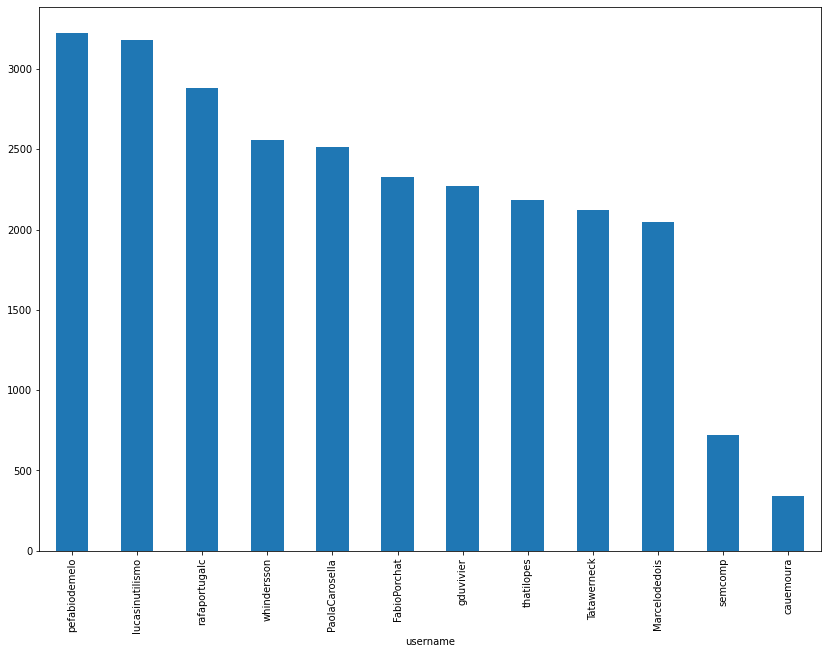

In [ ]:
count_by_user.plot(kind='bar', figsize=(14,10));

## Qual é o tweet com mais RTs?

In [ ]:
df.sort_values('retweet_count', ascending=True).head()

,created_at,id,username,text,retweet_count,favorite_count,text_en
16226,2018-10-27 17:59:45+00:00,1056244071499530244,FabioPorchat,@guimattielli =*,0,79,@guimattielli = *
13518,2015-03-13 23:52:57+00:00,576531425266110464,rafaportugalc,O Policial fardado estava parado apenas cumpri...,0,0,The uniformed Policeman was standing just foll...
13519,2017-05-08 12:38:37+00:00,861560972447801344,rafaportugalc,❤️ https://t.co/xODhd5LKTs https://t.co/8nO8Mk...,0,6,❤️ https://t.co/xODhd5LKTs https://t.co/8nO8Mk...
13526,2018-10-25 16:08:26+00:00,1055491283031068672,rafaportugalc,@suelenmsoares @jluizcarpes Faço show aí no do...,0,2,@suelenmsoares @jluizcarpes I play there on Su...
13527,2016-05-24 18:45:10+00:00,735179853192781824,rafaportugalc,Ta faltando pouquinho!!! Dia 30/06 https://t.c...,0,2,Ta missing a little !!! 06/30 https://t.co/BYr...


## Qual é o tweet com mais favorites?

In [ ]:
df.sort_values('favorite_count', ascending=False).head()

,created_at,id,username,text,retweet_count,favorite_count,text_en
23399,2020-09-10 23:30:05+00:00,1304200502100582401,whindersson,https://t.co/b91seY3ijl https://t.co/vktoyHymAj,75493,561782,https://t.co/b91seY3ijl https://t.co/vktoyHymAj
23840,2020-09-10 23:11:00+00:00,1304195700528476160,whindersson,O pai tá on desde maio,20324,440666,Dad is on since May
22884,2020-08-26 15:32:04+00:00,1298644389418405888,whindersson,Vacilei logo no final jow kkkkkkkk mta onda ht...,51535,416999,I vacillated right at the end jow kkkkkkkk mta...
22902,2020-09-11 00:16:17+00:00,1304212130607116288,whindersson,Curioso pra saber a opinião do Mc Poze sobre o...,20108,365916,Curious to know Mc Poze's opinion on the subject
12078,2020-04-18 02:23:17+00:00,1251335462968594434,rafaportugalc,"Alô. Quer falar com a Ivy? Ela tá aqui sim, ma...",74280,360267,"Hello. Do you want to talk to Ivy? Yes, she's ..."


## Qual é o usuário mais popular?
Popularidade = RTs + favorites

In [ ]:
df['popularity'] = df['retweet_count'] + df['favorite_count']
popularity = df.groupby('username').popularity.agg('sum').sort_values(ascending=False)
popularity

username
whindersson        88017956
pefabiodemelo      45839682
lucasinutilismo    17750255
PaolaCarosella     11047333
gduvivier          10831944
rafaportugalc       9933463
Marcelodedois       6644281
FabioPorchat        5806406
Tatawerneck         5010379
cauemoura           2427928
thatilopes            61461
semcomp                 698
Name: popularity, dtype: int64

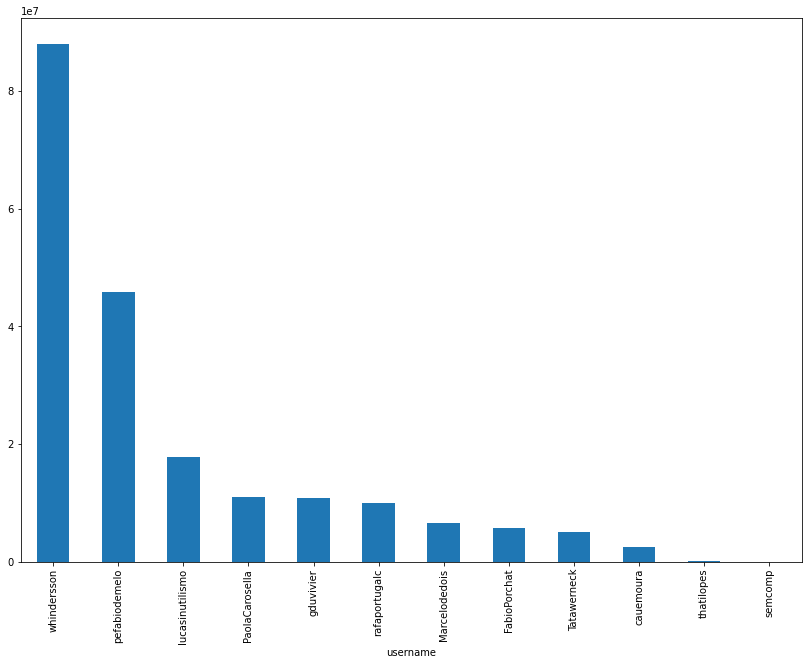

In [ ]:
popularity.plot(kind='bar', figsize=(14,10));

In [ ]:
df.head()

,created_at,id,username,text,retweet_count,favorite_count,text_en,popularity
0,2019-06-13 14:18:11+00:00,1139175135850696704,gduvivier,CIÚMES 2! https://t.co/9JirqkPLWE,2,71,JEALOUS 2! https://t.co/9JirqkPLWE,73
1,2020-08-27 13:45:13+00:00,1298979887731048448,gduvivier,to lá https://t.co/pVSYNiBq3r,10,99,to lá https://t.co/pVSYNiBq3r,109
2,2019-04-15 17:23:23+00:00,1117840857363877892,gduvivier,alguém tem o contato do Atila KW da banda Konv...,0,78,does anyone have contact with Atila KW from th...,78
3,2020-09-27 20:17:42+00:00,1310312682575273987,gduvivier,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,716,7676,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,8392
4,2020-05-25 00:31:12+00:00,1264715605841776641,gduvivier,"Também fiquei mal, como perceberam pela minha ...",6,282,"I also looked bad, as you can see from my face...",288


## Quais são as palavras mais utilizadas por um usuário?

In [ ]:
# Agrupando textos por usuário
text_by_user = df.groupby('username').text.agg(list)
text_by_user

username
FabioPorchat       [@LihBarrosz Só tenho dinheiro russo, @betosil...
Marcelodedois      [🌵🖤 https://t.co/H4OEkGTzWp, Live histórica ho...
PaolaCarosella     [@thaisdumet @VaiUmaMaozinhAi @MariliaMReal @m...
Tatawerneck        [@Vilsonoliveiraa Completei a vaquinha, @ReisT...
cauemoura          [POUCAS com João Gordo - https://t.co/bg6BsQZ3...
gduvivier          [CIÚMES 2! https://t.co/9JirqkPLWE, to lá http...
lucasinutilismo    [opa tudo bom\n\nhoje tem vídeo novo 20h, VÍDE...
pefabiodemelo      [Pronto, minha gente. Tá lançada. Escuta nóis....
rafaportugalc      [Que deliciaaaaa!!! https://t.co/S66xT8AFuf, E...
semcomp            [Saudades do meu mozão, volta pra mim semcomp....
thatilopes         [E a saudade q ja vai batendo? #fimdetemporada...
whindersson        [Rapaz vc acordar e ver uma merda dessa é revo...
Name: text, dtype: object

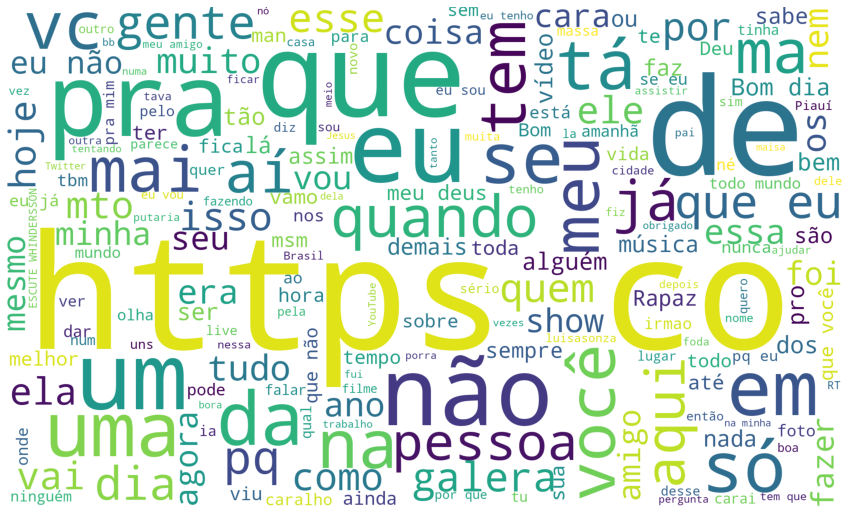

In [ ]:
# Visualizando em word cloud as palavras do whindersson
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

texts = text_by_user['whindersson']
stopwords = None
# stopwords = ['https',  'co'] # O que muda ?
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=2000, height=1200).generate(" ".join(texts))

fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud);

In [ ]:
# realizando o download de uma lista de stopswords em português
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
ptbr_stopwords = stopwords.words('portuguese')
ptbr_stopwords[0:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um']

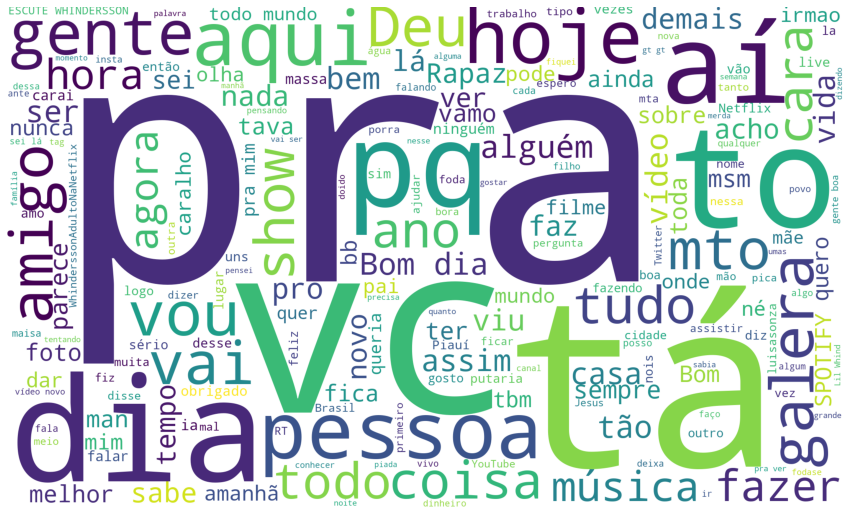

In [ ]:
texts = text_by_user['whindersson']
stopwords = ptbr_stopwords + ['https',  'co'] # O que muda ?
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=2000, height=1200).generate(" ".join(texts))

fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud);

## Qual é usuário com tweets mais negativos? e positivos?

[TextBlob](https://textblob.readthedocs.io/en/dev/) é uma biblioteca de processamento de texto, e nela conseguimos extrair de forma fácil a polaridade do sentimento de um tweet em inglês
- -1 => Sentimento negativo
- 0 => Sentimento neutro
- +1 => Sentimento positivo

In [ ]:
from textblob import TextBlob

In [ ]:
TextBlob("Semcomp is very nice!").polarity

0.9750000000000001

In [ ]:
TextBlob("How are you?").polarity

0.0

In [ ]:
TextBlob("This is bad").polarity

-0.6999999999999998

In [ ]:
def extract_polarity(text):
    return TextBlob(text).polarity

In [ ]:
df['tweet_polarity'] = df['text_en'].apply(extract_polarity)

In [ ]:
df.head()

,created_at,id,username,text,retweet_count,favorite_count,text_en,popularity,tweet_polarity
0,2019-06-13 14:18:11+00:00,1139175135850696704,gduvivier,CIÚMES 2! https://t.co/9JirqkPLWE,2,71,JEALOUS 2! https://t.co/9JirqkPLWE,73,0.00
1,2020-08-27 13:45:13+00:00,1298979887731048448,gduvivier,to lá https://t.co/pVSYNiBq3r,10,99,to lá https://t.co/pVSYNiBq3r,109,0.00
2,2019-04-15 17:23:23+00:00,1117840857363877892,gduvivier,alguém tem o contato do Atila KW da banda Konv...,0,78,does anyone have contact with Atila KW from th...,78,0.00
3,2020-09-27 20:17:42+00:00,1310312682575273987,gduvivier,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,716,7676,https://t.co/4ak4gwk4Wb https://t.co/Q7nDGFlS6k,8392,0.00
4,2020-05-25 00:31:12+00:00,1264715605841776641,gduvivier,"Também fiquei mal, como perceberam pela minha ...",6,282,"I also looked bad, as you can see from my face...",288,-0.35


In [ ]:
positive_tweets = df[df['tweet_polarity'] > 0]
neutral_tweets = df[df['tweet_polarity'] == 0]
negative_tweets = df[df['tweet_polarity'] < 0]

In [ ]:
positive_tweets.groupby('username').id.nunique().sort_values(ascending=False)

username
pefabiodemelo      1173
Tatawerneck        1104
rafaportugalc      1075
PaolaCarosella     1007
lucasinutilismo     974
whindersson         935
thatilopes          917
FabioPorchat        798
Marcelodedois       750
gduvivier           671
semcomp             341
cauemoura           102
Name: id, dtype: int64

In [ ]:
negative_tweets.groupby('username').id.nunique().sort_values(ascending=False)

username
pefabiodemelo      617
lucasinutilismo    437
whindersson        393
PaolaCarosella     385
Marcelodedois      346
rafaportugalc      272
gduvivier          264
Tatawerneck        198
FabioPorchat       174
thatilopes         162
semcomp             81
cauemoura           72
Name: id, dtype: int64

In [ ]:
neutral_tweets.groupby('username').id.nunique().sort_values(ascending=False)

username
lucasinutilismo    1767
rafaportugalc      1533
pefabiodemelo      1434
FabioPorchat       1352
gduvivier          1336
whindersson        1229
PaolaCarosella     1122
thatilopes         1102
Marcelodedois       950
Tatawerneck         818
semcomp             300
cauemoura           166
Name: id, dtype: int64

# Comparação com DBs Relacionais

E esse formato de dados é muito familiar com a estrutura utilizada em bancos de dados, como o PostgreSQL, onde utilizamos SQL para realizar consultas de extração de dados, onde o processamento e manipulação dos dados é otimizado.

Exemplo de SQL para contar tweets únicos por usuário:

```
SELECT username, COUNT(DISTINCT id) FROM tweets GROUP BY username;
```
